# Demonstrating Violation of Bell's Inequality

This tutorial shows how to run a version of Bell's inequality experiment in Braket on different QPUs.  


## EPR state

Consider two spin-1/2 particles in the singlet state:
$$ |\psi^{-}\rangle = \frac{1}{\sqrt{2}} \left(|0\rangle_{Alice}|1\rangle_{\text Bob} - |1\rangle_{Alice}|0\rangle_{\text Bob}  \right).$$

Suppose the particles are separated and sent to different experimentalists: Alice and Bob. The property of interest is that the two particles are entangled. If a measurement on particle 1 along $\mathbf{\hat n}$ gives $+1$, then measuring particle 2 in $\mathbf{\hat n}$ will give $-1$. This is perfect anti-correlation when both particles are measured in the same basis. A remarkable property of quantum mechancis is that this anti-correlation is basis independent. If the pair is entangled, it's entangled in all possible measurement bases. 


What about the case where Alice measures in $\mathbf{\hat n_1}$ and Bob measures in a different directoin $\mathbf{\hat n_2}$? 
It can be shown that the expected value of the measurement outcomes is

$$E^{\psi^{-}}(\mathbf{\hat n_1}, \mathbf{\hat n_2}) = -\cos\left(\theta_{\mathbf{\hat n_1}, \mathbf{\hat n_2}}\right) $$

where $\theta_{\mathbf{\hat n_1}, \mathbf{\hat n_2}}$ is the angle between the two directions.  If $\mathbf{\hat n_1}$ and $\mathbf{\hat n_2}$ are aligned (angle between them is 0), then the results will be perfectly anticorrelated. If they are perpendicular (angle $\pi/2$), the results will be independent.

## Bell's Inequality

Bell's experiment considers that would happen if Alice and Bob each measure in two different directions.Alice will measure in $\mathbf{\hat a}$ and $\mathbf{\hat b}$, while Bob will measure in $\mathbf{\hat a}$ and $\mathbf{\hat c}$.

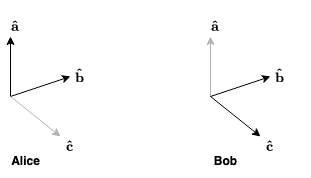


Bell derived that if there was some pre-existing physical property that the measurement "uncovers", and if the measurements are not causally related, then the expectation values of the singlet state must obey:

$$ |E^{\psi^{-}}(\mathbf{\hat a}, \mathbf{\hat b})  - E^{\psi^{-}}(\mathbf{\hat a}, \mathbf{\hat c})| - E^{\psi^{-}}(\mathbf{\hat b}, \mathbf{\hat c})  \leq 1$$

for three directions $\mathbf{\hat a}, \mathbf{\hat b}, \mathbf{\hat c}$. Violation of this inequality undermines the assumptions of local hidden variables to explain entanglement.  This is the original version of Bell's inequality [1]. 

Without loss of generality, we choose $\mathbf{\hat a}, \mathbf{\hat b}, \mathbf{\hat c}$ to lie in the $y-z$ plane. We can also choose  $\mathbf{\hat a} = \mathbf{\hat z}$ so that $\mathbf{\hat b}, \mathbf{\hat c}$ are completely defined by their angles $\theta_{\mathbf{\hat b}}$ and $\theta_{\mathbf{\hat c}}$ from the $z$-axis. Bell's inequality then becomes 

$$
|-\cos\theta_{\mathbf{\hat b}} + \cos\theta_{\mathbf{\hat c}}|  + \cos(\theta_{\mathbf{\hat c}}-\theta_{\mathbf{\hat b}}) \leq 1
$$
In the cell below, we plot the lef-hand-side of this equation for various values of $\theta_{AB}, \theta_{BC}$. The maximum value is $1.5 \nleq 1$ which occurs at $\theta_{\mathbf{\hat b}}=\pi/3$,  $\theta_{\mathbf{\hat c}} = 2\pi/3$as confirmed in the plot. 

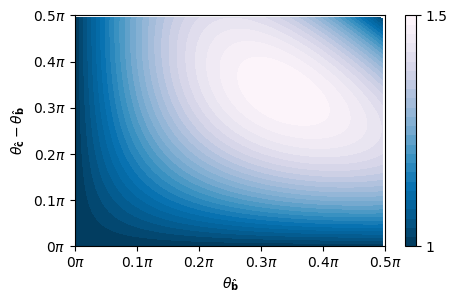

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm, ticker

N = 1_00
a, b = np.mgrid[0:N, 0:N] / (2 * N)
bell_terms = np.abs(np.cos(a * np.pi + b * np.pi) - np.cos(a * np.pi)) + np.cos(
    b * np.pi
)

fig, ax = plt.subplots(figsize=(5, 3))
cs = ax.contourf(a, b, bell_terms, cmap=cm.PuBu_r, levels=30)
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter(r"%g$\pi$"))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter(r"%g$\pi$"))
cbar = fig.colorbar(cs, ticks=[1, 1.5])
cbar.ax.set_yticklabels(["1", "1.5"])
ax.set(
    xlim=(0, 0.5),
    ylim=(0, 0.5),
    xlabel=r"$\theta_{\mathbf{\hat b}}$",
    ylabel=r"$\theta_{\mathbf{\hat c}}-\theta_{\mathbf{\hat b}}$",
)
plt.show()

## Testing  Bell's inequality on quantum computers

We start by preparing the Bell singlet state in Braket. 

In [2]:
from braket.aws import AwsDevice, AwsQuantumTask
from braket.circuits import Circuit, Gate, Observable
from braket.devices import LocalSimulator

In [3]:
def bell_singlet(qubit0, qubit1):
    return Circuit().x(qubit0).x(qubit1).h(qubit0).cnot(qubit0, qubit1)

In [4]:
print(bell_singlet(0, 1))

T  : |0|1|2|
            
q0 : -X-H-C-
          | 
q1 : -X---X-

T  : |0|1|2|


Next, we want to measure in different basis defined by $\mathbf{\hat b}$ or $\mathbf{\hat c}$. Since the directions lie  in the $y-z$ plane, we can get we must rotate the state by by $\theta_{\mathbf{\hat b}}$ and $\theta_{\mathbf{\hat c}}$ around the $x$-axis using a rotation gate $Rx(\theta)$. Alice applies rotation $Rx(\theta)$ on the first spin, and Bob applied $Rx(\theta)$ to the second spin. The three experiments we need to perform are summarized in the table below.

|  | $\text{Alice}$   | $\text{Bob}$  |
| :-: | :-: | :-: |
| AB | $0$     | $\pi/3$  |
| AC | $0$     | $2\pi/3$ |
| BC | $\pi/3$ | $2\pi/3$ |


In [5]:
def bell_singlet_rotated(qubit0, qubit1, rotation0, rotation1):
    c = bell_singlet(qubit0, qubit1)
    if rotation0 != 0:
        c = c.rx(qubit0, rotation0)
    if rotation1 != 0:
        c = c.rx(qubit1, rotation1)
    c.sample(Observable.Z())
    return c

The three Bell circuits to run are:

In [6]:
circAB = bell_singlet_rotated(0, 1, 0, np.pi / 3.0)
circAC = bell_singlet_rotated(0, 1, 0, 2 * np.pi / 3.0)
circBC = bell_singlet_rotated(0, 1, np.pi / 3.0, 2 * np.pi / 3.0)
print(circBC)

T  : |0|1|2|   3    |Result Types|
                                
q0 : -X-H-C-Rx(1.05)-Sample(Z)----
          |          |          
q1 : -X---X-Rx(2.09)-Sample(Z)----

T  : |0|1|2|   3    |Result Types|


In [7]:
res = [
    LocalSimulator().run(circ, shots=10_000).result().measurement_probabilities
    for circ in [circAB, circAC, circBC]
]
prob_same = [d["00"] + d["11"] for d in res]
prob_different = [d["01"] + d["10"] for d in res]
pAB, pAC, pBC = np.array(prob_same) - np.array(prob_different)
print(
    f"P(a,b) = {pAB},P(a,c) = {pAC},P(b,c) = {pBC}\nBell inequality: {np.abs(pAB - pAC) - pBC} ≤ 1"
)

P(a,b) = -0.4938,P(a,c) = 0.5042,P(b,c) = -0.5047999999999999
Bell inequality: 1.5028 ≤ 1


The Bell inequality is violated just as predicted by quantum mechanics! 

# Running on QPUs

Let's wrap those methods into a function so we can easily run on different QPUs.

In [8]:
def submit_bell_tasks(device, shots=1_000):
    circAB = bell_singlet_rotated(0, 1, 0, np.pi / 3.0)
    circAC = bell_singlet_rotated(0, 1, 0, 2 * np.pi / 3.0)
    circBC = bell_singlet_rotated(0, 1, np.pi / 3.0, 2 * np.pi / 3.0)
    tasks = [device.run(circ, shots=shots) for circ in [circAB, circAC, circBC]]
    return tasks


def get_results(tasks, verbose=True):
    results = [task.result().measurement_probabilities for task in tasks]
    prob_same = [d["00"] + d["11"] for d in results]
    prob_different = [d["01"] + d["10"] for d in results]
    pAB, pAC, pBC = np.array(prob_same) - np.array(prob_different)
    if verbose == True:
        print(
            f"P(a,b) = {pAB},P(a,c) = {pAC},P(b,c) = {pBC}\nBell inequality: {np.abs(pAB - pAC) - pBC} ≤ 1"
        )
    return results, pAB, pAC, pBC

First we test the Bell inequality on OQC Lucy device. The cost to run this experiment is $\$ 0.3$ per task and $\$0.00035$ per shot.  Since we have three circuits of 1000 shots each, that totals $\$1.95$ USD.

**Cost: $\$1.95$ USD**

In [9]:
oqc_lucy = AwsDevice("arn:aws:braket:eu-west-2::device/qpu/oqc/Lucy")
oqc_tasks = submit_bell_tasks(oqc_lucy)

If above taking long time, you can check your tasks if queued: https://us-east-1.console.aws.amazon.com/braket/home?region=eu-west-2#/tasks

In [10]:
results, pAB, pAC, pBC = get_results(ionq_tasks)

P(a,b) = -0.451,P(a,c) = 0.488,P(b,c) = -0.431
Bell inequality: 1.37 ≤ 1


Bell's inequality is violated! Notice that the quantity is not exactly $1.5$ as predicted by theory. This is due to the effects of noise on the QPU. See https://github.com/aws/amazon-braket-examples/blob/main/examples/braket_features/Noise_models/Noise_models_on_Rigetti_AspenM2.ipynb for an example of modeling the noise properties of a QPU. 

Next, we submit our example Bell state circuit to IonQ. This task may not readily be executed but enter a queue for this specific machine. While we can interrupt our kernel (and work on something else), we can always recover our results using the unique ID of this task.

**Cost: $\$30$ USD**

In [11]:
ionq_harmony = AwsDevice("arn:aws:braket:::device/qpu/ionq/ionQdevice")
ionq_tasks = submit_bell_tasks(ionq_harmony)

In [12]:
results, pAB, pAC, pBC = get_results(ionq_tasks)

P(a,b) = -0.476,P(a,c) = 0.496,P(b,c) = -0.45599999999999996
Bell inequality: 1.428 ≤ 1


Again, we see that Bell's inequality is violated. 

## References

[1]  Bell, J. S. On the Einstein Podolsky Rosen Paradox. Physics Physique Fizika 1, no. 3 (November 1, 1964): 195–200. https://doi.org/10.1103/PhysicsPhysiqueFizika.1.195.


[2] Greenberger, Daniel M., Michael A. Horne, Abner Shimony, and Anton Zeilinger (1990). Bell’s Theorem without Inequalities. American Journal of Physics 58, no. 12: 1131–43. https://doi.org/10.1119/1.16243.